# Important information about this EDA, (Exploratory Data Analysis)
Exploring the files in the 'data/processed/' directory<br>

**Please note:** The analysis will be divided into four distinct sections, each addressing different files, as outlined below::
- App usage in the phone, (Files: 'app_usage_count_motorola.csv' and 'app_usage_time_motorola.csv')
- Device unlocks analysis, (Files: 'device_unlocks_motorola.csv')
- Web usage count, (Files: 'web_usage_count_chrome.csv', 'web_usage_count_edge.csv', 'web_usage_count_motorola.csv')
- Web usage time, (Files: 'web_usage_time_chrome.csv', 'web_usage_time_edge.csv', 'web_usage_time_motorola.csv')

*App usage time* and *Web usage time* files have every column except the date to be in minutes.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_theme(style="whitegrid")

# Exploratory Data Analysis

## App usage in the phone

Connection to the sql server database

In [23]:
def read_from_sql_database(server, database, username, password, driver, queries):
    # Creating the SQLAlchemy connection
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"
    engine = create_engine(connection_string)
    dataframes = {}
    for query in queries:
        dataframes[query.split()[-1]] = pd.read_sql(query, engine, parse_dates=['date'])
        
    return dataframes

# Connection parameters
server = 'DESKTOP-8PK64UI'
database = 'statistics_of_use_db'
username = 'main_estiven'
driver = 'ODBC+Driver+17+for+SQL+Server'

password_file_path = "database_pass.txt"
with open(password_file_path, "r") as file:
    password = file.read().strip()

Reading the files for App usage in the phone

In [24]:
sql_queries = ["SELECT * FROM app_usage_count_motorola", "SELECT * FROM app_usage_time_motorola", 
               "SELECT * FROM web_usage_time_edge", "SELECT * FROM device_unlocks_motorola"]
result_df = read_from_sql_database(server, database, username, password, driver, sql_queries)

app_count_motorola = result_df['app_usage_count_motorola']
app_time_motorola = result_df['app_usage_time_motorola']
web_time_edge = result_df['web_usage_time_edge']
device_unlocks = result_df['device_unlocks_motorola']

count_columns = list(app_count_motorola.columns)
time_columns = list(app_time_motorola.columns)

Overview of the datasets

In [25]:
print(f'App count motorola:\n{app_count_motorola.head(1)}\n')
print(f'App count motorola:\n{app_time_motorola.head(1)}\n')
print(f'Web time edge:\n{web_time_edge.head(1)}\n')
print(f'Device unlocks:\n{device_unlocks.head(1)}\n')

App count motorola:
        date  amazon_shopping  android_system  calculator  calendar  camera  chrome  classroom  clock  discord  drive  files  gmail  google  google_news  google_opinion_rewards  google_play_services  google_play_store  instagram  linkedin  maps  medium  mi_tigo  microsoft_365_(office)  moto_app_launcher  nequi_colombia  notion  package_installer  photomath  photos  settings  siata  simcity  spotify  stellarium  symbolab  system_ui  tasks  teams  telegram  tiktok  truecaller  twitter  tyba  upwork_talent  whatsapp  youtube  youtube_music  zoom  total_usage  apple_music  didi  freelancer  money_manager  paypal  sleepy  call_of_duty  chatgpt  cívica  clash_of_clans  hbo_max  rappi
0 2022-10-19              0.0             1.0         5.0       3.0     0.0    24.0        5.0    8.0      0.0   11.0    2.0    4.0     0.0          4.0                     2.0                   1.0                0.0       33.0       0.0   0.0     0.0      0.0                     0.0        

In [26]:
print(f'Shape of the motorola time usage dataframe, (ORIGINAL): {app_time_motorola.shape}\n\
Shape of the motorola count usage dataframe, (ORIGINAL): {app_count_motorola.shape}\n\
Shape of the edge time usage dataframe, (ORIGINAL): {web_time_edge.shape}\n\
Shape of the motorola unlocks dataframe, (ORIGINAL): {device_unlocks.shape}\n')

Shape of the motorola time usage dataframe, (ORIGINAL): (552, 52)
Shape of the motorola count usage dataframe, (ORIGINAL): (552, 62)
Shape of the edge time usage dataframe, (ORIGINAL): (330, 39)
Shape of the motorola unlocks dataframe, (ORIGINAL): (552, 2)



## Data transformation and cleaning

In [27]:
def percentage_of_zeros(dataframe: pd.DataFrame, dataframe_column: str) -> float:
    """
    Calculate the percentage of zero values in a specific column of a pandas DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    dataframe_column (str): The column name for which the percentage of zero values should be calculated.

    Returns:
    float: The percentage of zero values in the specified column, rounded to two decimal places.

    Example:
    >>> import pandas as pd
    >>> data = {'column_A': [0, 0, 3, 0, 5, 0, 0]}
    >>> df = pd.DataFrame(data)
    >>> percentage = percentage_of_zeros(df, 'column_A')
    >>> print(percentage)
    71.43
    """
    percentage_zeros = (dataframe[dataframe_column] == 0).astype(int).sum(axis=0) / dataframe.shape[0]
    return round(percentage_zeros * 100, 2)

Filtering the data so there are not too much zeros

In [28]:
# Creating a dictionary of the column name and its percentage of zeros
percentages_count = {}
for column in app_count_motorola:
    if column != 'date':
        percentages_count[column] = percentage_of_zeros(app_count_motorola, column)

# Filtering the data, columns with a percentage more than 70 of zeros will be dropped
columns_too_much_zeros_count = [key for key, value in percentages_count.items() if value > 70]
app_count_motorola = app_count_motorola.drop(columns=columns_too_much_zeros_count)

# Same code but for time data
percentages_time = {}
for column in app_time_motorola:
    if column != 'date':
        percentages_time[column] = percentage_of_zeros(app_time_motorola, column)

columns_too_much_zeros_time = [key for key, value in percentages_time.items() if value > 70]
app_time_motorola = app_time_motorola.drop(columns=columns_too_much_zeros_time)
app_time_motorola.head()

,date,calculator,chrome,clock,drive,gmail,google,google_play_store,instagram,linkedin,maps,mi_tigo,microsoft_365_(office),moto_app_launcher,nequi_colombia,photos,settings,spotify,tasks,truecaller,twitter,whatsapp,youtube,total_usage
0,2022-10-19,3.02,17.48,1.75,55.68,1.92,0.00,0.00,50.30,0.00,0.00,0.00,0.0,12.78,0.0,0.00,2.25,10.28,0.0,0.00,0.0,73.10,0.00,270.33
1,2022-10-20,1.57,5.28,0.90,11.72,0.00,0.00,0.00,46.17,0.00,1.15,0.00,0.0,11.62,0.0,0.00,3.30,2.78,0.0,0.02,0.0,61.83,12.98,265.90
2,2022-10-21,0.00,1.37,0.68,1.55,6.32,0.00,0.08,40.90,0.00,0.80,1.18,0.0,7.90,0.0,0.67,0.85,0.00,0.0,0.35,0.0,62.60,0.00,239.60
3,2022-10-22,0.00,1.98,0.00,0.00,1.72,0.13,2.23,69.20,0.03,0.00,0.00,0.0,10.12,0.0,52.60,0.15,0.00,0.0,0.00,0.0,113.32,33.82,373.78
4,2022-10-23,0.52,5.80,1.43,0.00,5.58,0.00,0.15,41.65,0.00,0.13,0.00,0.0,10.70,0.0,5.12,0.52,0.00,0.0,0.07,0.0,50.78,95.12,452.84


In [29]:
print(f'Shape of the motorola time usage dataframe: {app_time_motorola.shape}\n\
Shape of the motorola count usage dataframe: {app_count_motorola.shape}\n\
Shape of the edge time usage dataframe: {web_time_edge.shape}\n\
Shape of the motorola unlocks dataframe: {device_unlocks.shape}\n')

Shape of the motorola time usage dataframe: (552, 24)
Shape of the motorola count usage dataframe: (552, 27)
Shape of the edge time usage dataframe: (330, 39)
Shape of the motorola unlocks dataframe: (552, 2)



Top 5 most used applications in my phone and web browser Edge

In [30]:
most_used_apps_phone = app_time_motorola.loc[:, ~app_time_motorola.columns.isin(['date', 'total_usage'])].sum().sort_values(ascending=False)[:5] / 60
most_used_apps_phone = pd.DataFrame(most_used_apps_phone, index=None, columns=['total_usage (hours)']).reset_index().rename({'index': 'app_name'}, axis=1)
most_used_apps_phone

,app_name,total_usage (hours)
0,whatsapp,636.729125
1,instagram,504.435154
2,youtube,277.841353
3,chrome,115.225941
4,spotify,57.470743


In [31]:
most_used_web_edge = web_time_edge.loc[:, ~web_time_edge.columns.isin(['date', 'total_usage'])].sum().sort_values(ascending=False)[:5] / 60
most_used_web_edge = pd.DataFrame(most_used_web_edge, index=None, columns=['total_usage (hours)']).reset_index().rename({'index': 'app_name'}, axis=1)
most_used_web_edge

,app_name,total_usage (hours)
0,youtube.com,601.036833
1,instagram.com,59.452000
2,hbomax.com,52.381500
3,whatsapp.com,50.027833
4,chat.openai.com,45.418000


In [32]:
# Get the unique dates in each dataframe
device_dates = set(device_unlocks['date'].unique())
app_dates = set(app_time_motorola['date'].unique())

# Find dates that are in device_dates but not in app_dates
missing_in_app = device_dates.difference(app_dates)

# Find dates that are in app_dates but not in device_dates
missing_in_device = app_dates.difference(device_dates)

# Print missing dates
print("Dates missing in app_time_motorola:", missing_in_app)
print("Dates missing in device_unlocks:", missing_in_device)

# If you want to save these in a list, just convert the sets to lists
missing_in_app_list = list(missing_in_app)
missing_in_device_list = list(missing_in_device)

Dates missing in app_time_motorola: set()
Dates missing in device_unlocks: set()


# Exploratory Data Analysis phone usage

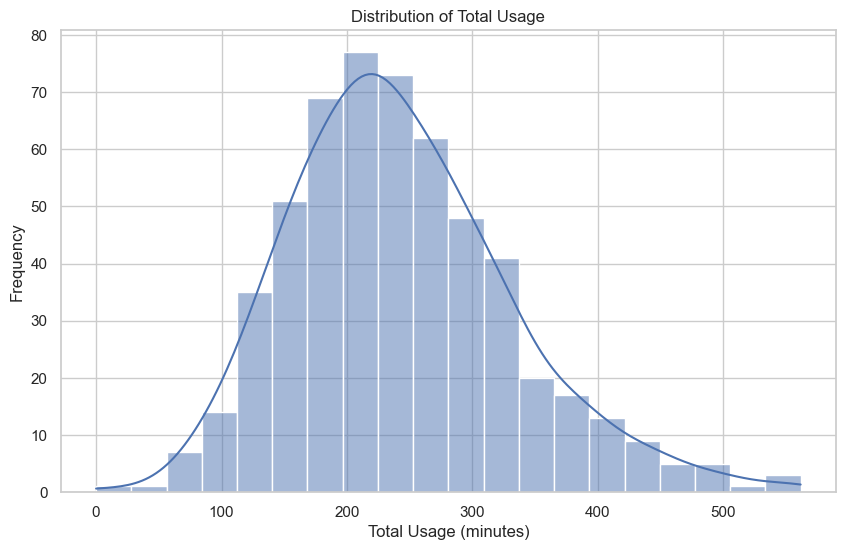

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(app_time_motorola['total_usage'], bins=20, kde=True)
plt.title('Distribution of Total Usage')
plt.xlabel('Total Usage (minutes)')
plt.ylabel('Frequency')
plt.show()

In [34]:
app_columns = app_time_motorola.columns[1:-1]

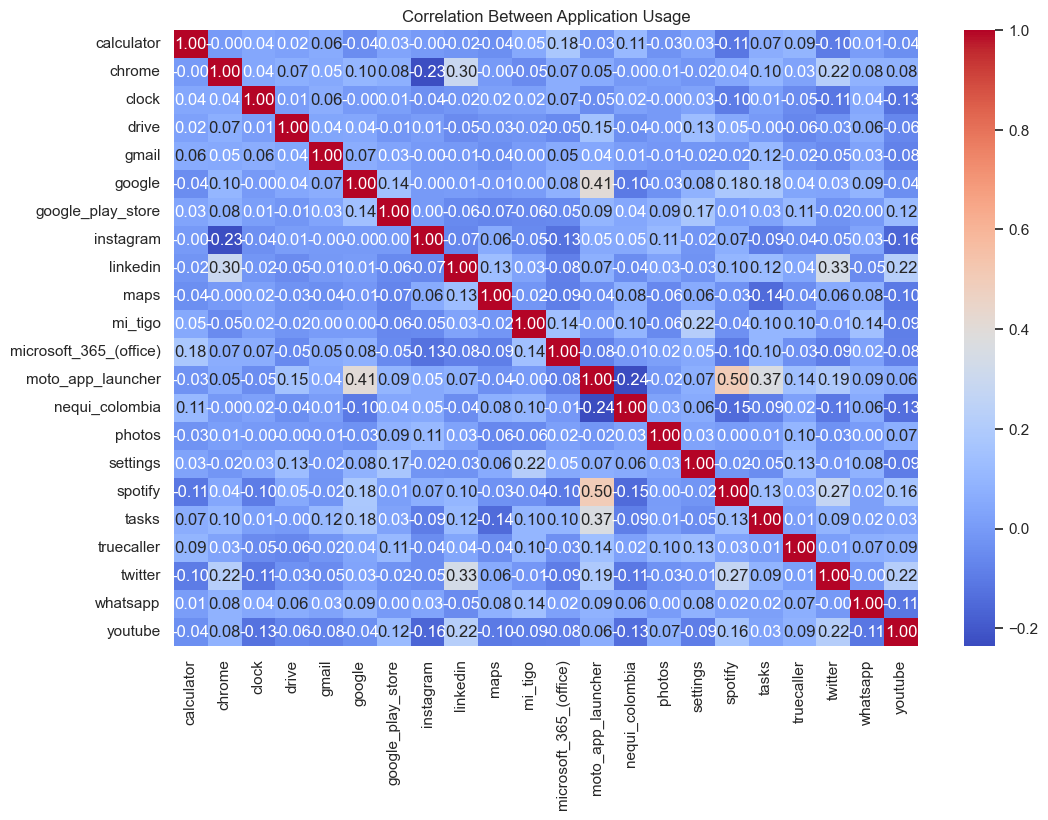

In [35]:
plt.figure(figsize=(12, 8))
sns.heatmap(app_time_motorola[app_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Application Usage')
plt.show()

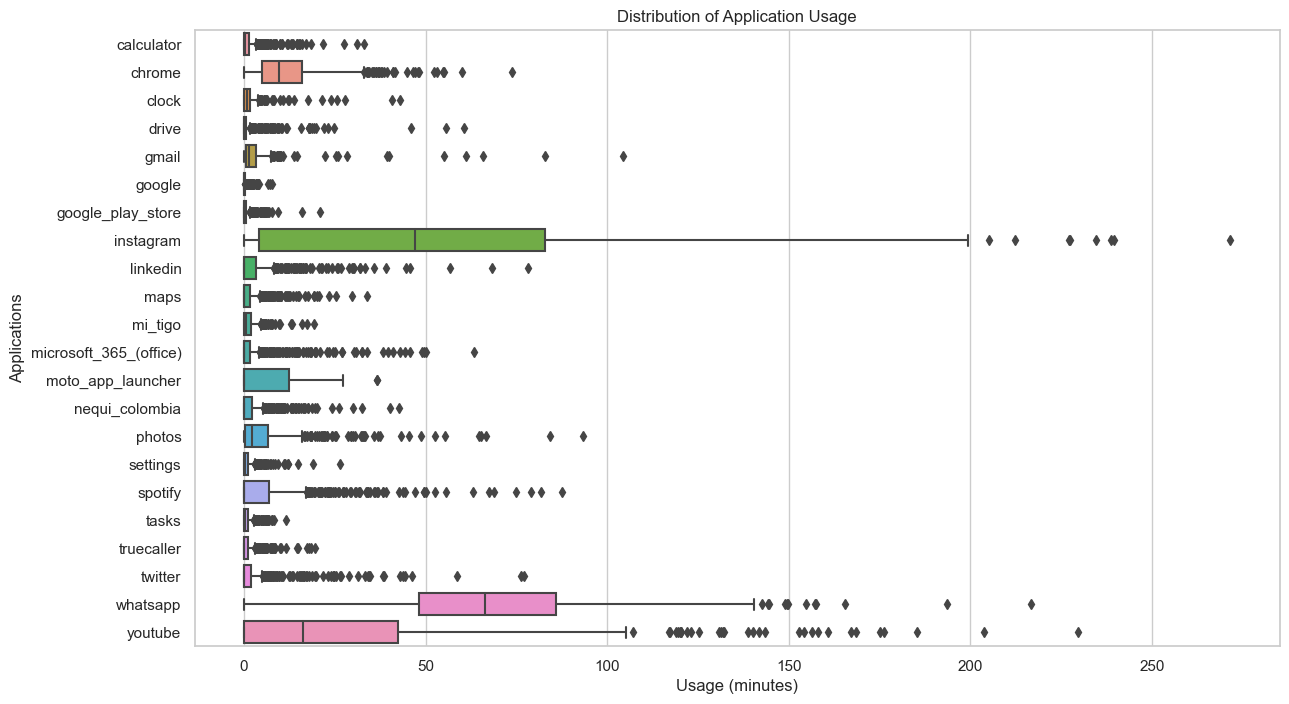

In [36]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=app_time_motorola[app_columns], orient='h')
plt.title('Distribution of Application Usage')
plt.xlabel('Usage (minutes)')
plt.ylabel('Applications')
plt.show()

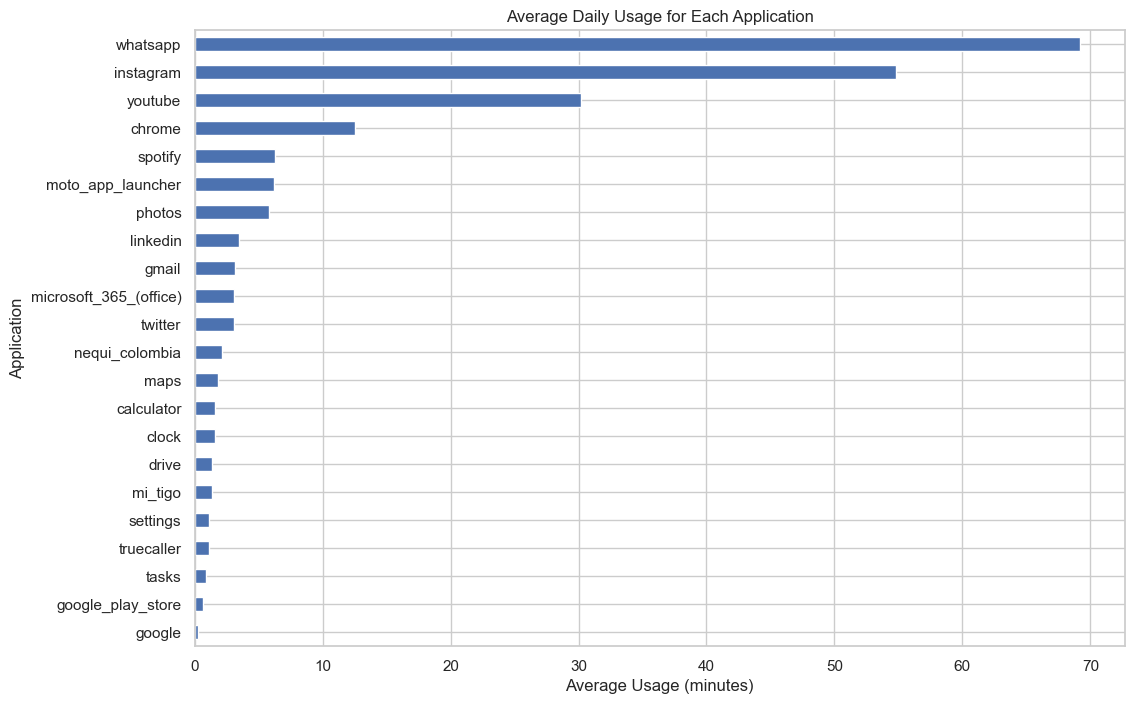

In [37]:
# Calculate average daily usage for each application
daily_avg_usage = app_time_motorola[app_columns].mean()

# Plotting average daily usage for each application
plt.figure(figsize=(12, 8))
daily_avg_usage.sort_values().plot(kind='barh')
plt.title('Average Daily Usage for Each Application')
plt.xlabel('Average Usage (minutes)')
plt.ylabel('Application')
plt.show()


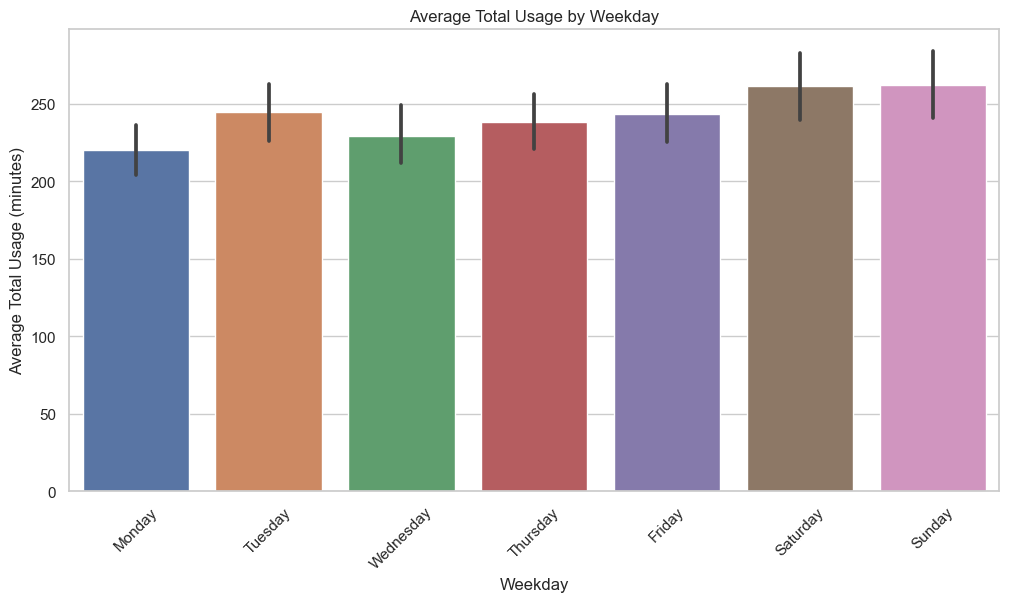

In [38]:
# Extract weekday from the date column
app_time_motorola['weekday'] = pd.to_datetime(app_time_motorola['date']).dt.weekday

# Map weekday numbers to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
app_time_motorola['weekday_name'] = app_time_motorola['weekday'].map(weekday_names)

# Plotting average usage by weekday
plt.figure(figsize=(12, 6))
sns.barplot(x='weekday_name', y='total_usage', data=app_time_motorola, order=weekday_names.values())
plt.title('Average Total Usage by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Total Usage (minutes)')
plt.xticks(rotation=45)
plt.show()


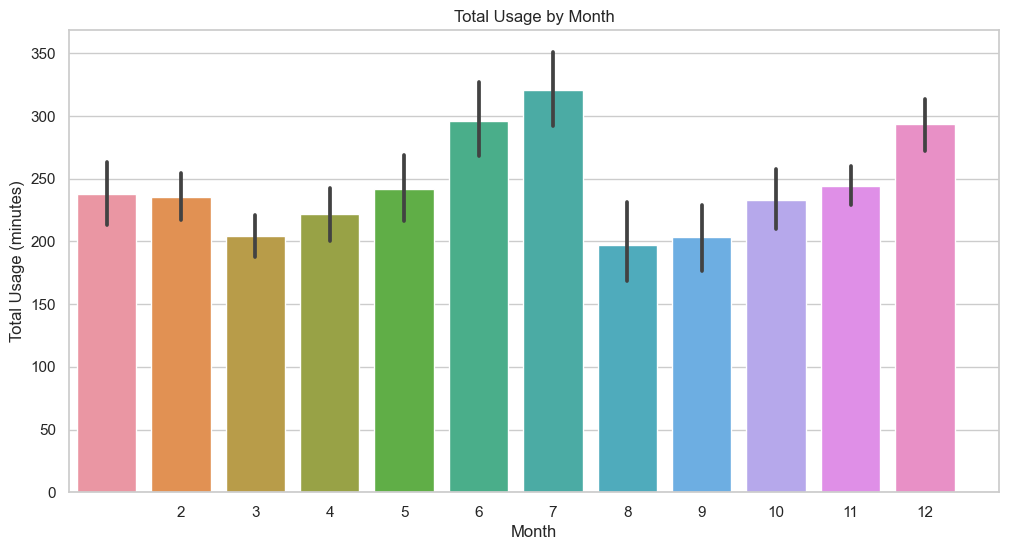

In [39]:
# Extract month from the date column
app_time_motorola['month'] = pd.to_datetime(app_time_motorola['date']).dt.month

# Plotting total usage by month
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_usage', data=app_time_motorola)
plt.title('Total Usage by Month')
plt.xlabel('Month')
plt.ylabel('Total Usage (minutes)')
plt.xticks(range(1, 13))
plt.show()


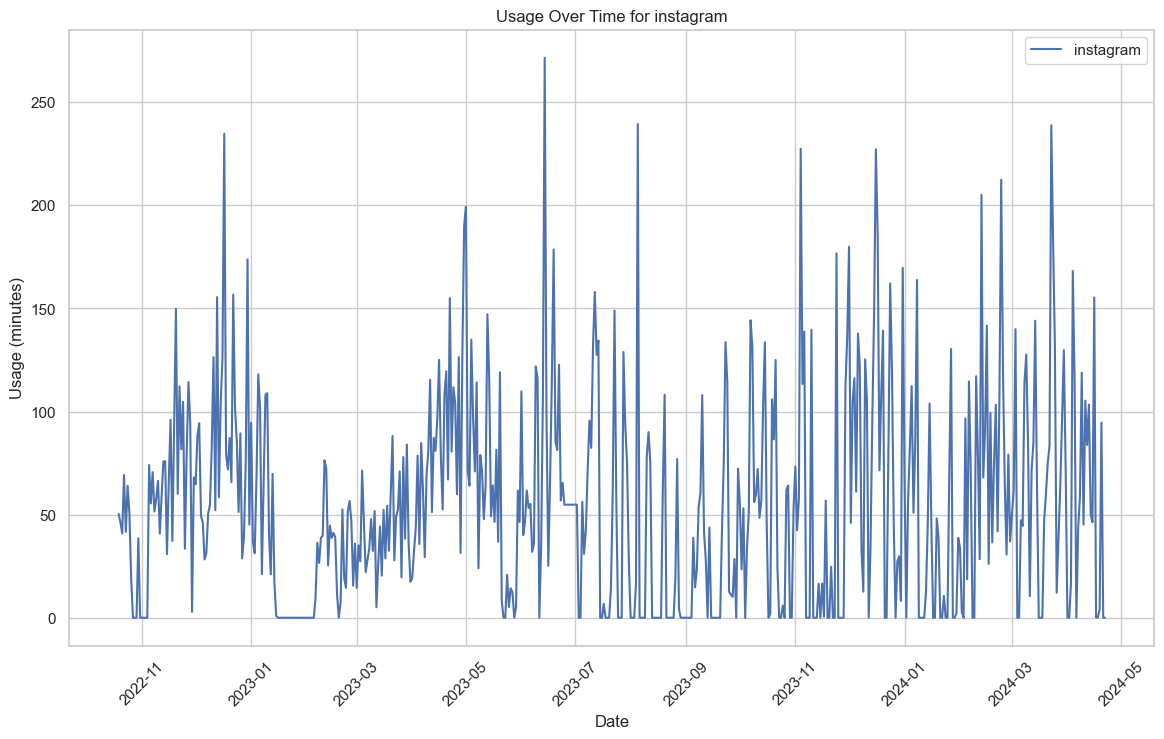

In [40]:
# Define the application to consider
app = 'instagram'

# Plotting usage of the application over time
plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y=app, data=app_time_motorola, label=app)
plt.title(f'Usage Over Time for {app}')
plt.xlabel('Date')
plt.ylabel('Usage (minutes)')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

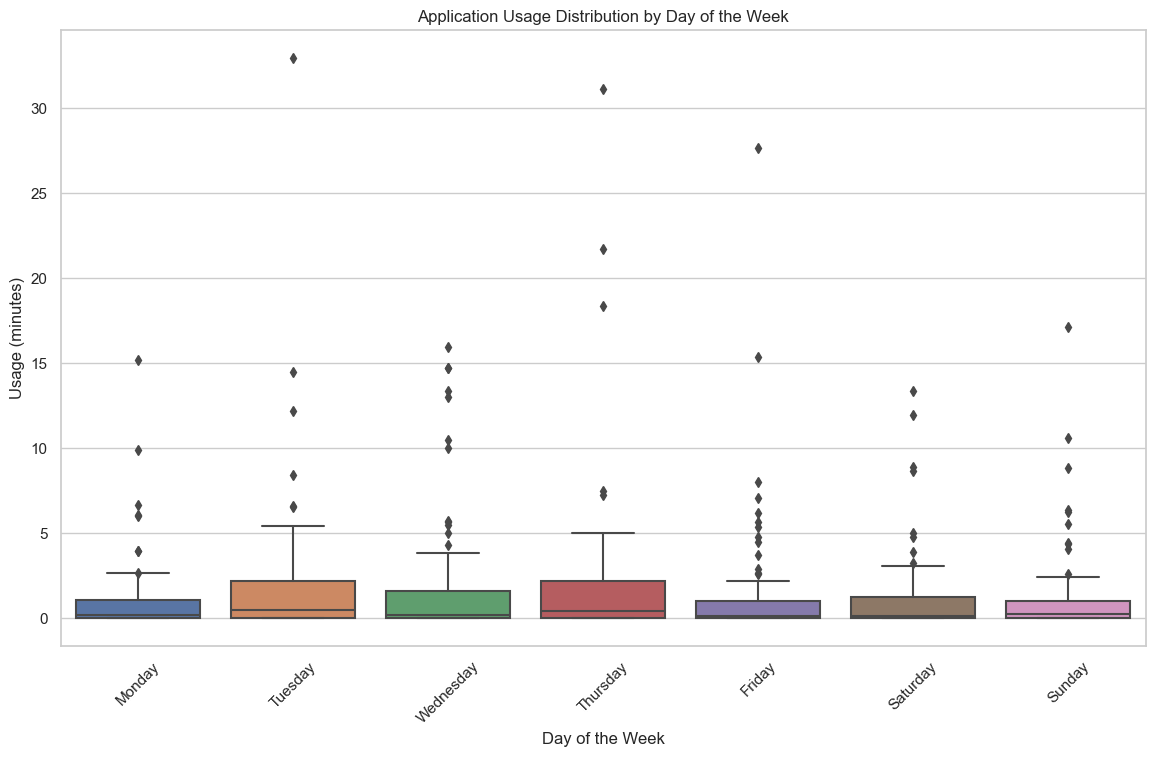

In [41]:
# Plotting application usage distribution by day of the week
plt.figure(figsize=(14, 8))
sns.boxplot(data=app_time_motorola, x='weekday_name', y=app_columns[0], order=weekday_names.values())
plt.title('Application Usage Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Usage (minutes)')
plt.xticks(rotation=45)
plt.show()

d:\Estiven\Datos\virtual-envs\statistics_of_use_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


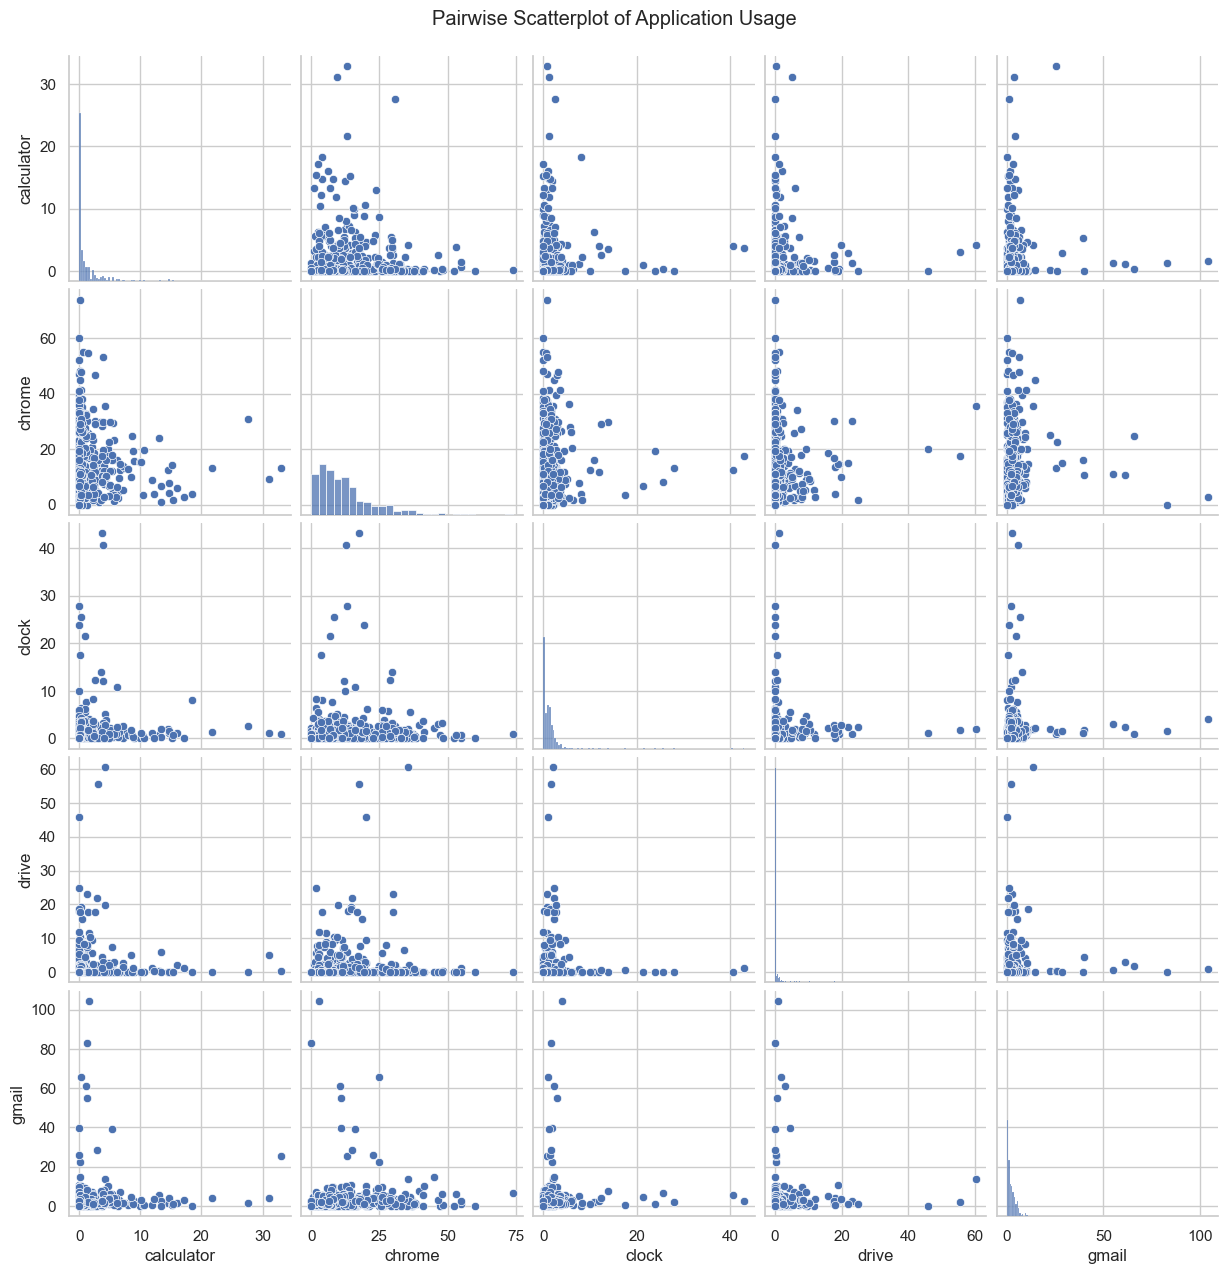

In [42]:
# Select a subset of applications for pairwise scatterplot
subset_apps = app_columns[:5]  # Selecting the first 5 applications for visualization

# Plotting pairwise scatterplot of application usage
sns.pairplot(data=app_time_motorola, vars=subset_apps)
plt.suptitle('Pairwise Scatterplot of Application Usage', y=1.02)
plt.show()